# Artifact channels identification from an HD-EMG array

Nicolly Kobayashi  
Renato Watanabe

## Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import libraries

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
from matplotlib import pylab
from google.colab import widgets
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import LinearNDInterpolator
from scipy.spatial import Delaunay
from scipy.ndimage import gaussian_filter
from skimage import data
from skimage import img_as_float
from skimage.morphology import reconstruction, diameter_opening, square
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import confusion_matrix
from jax import lax

In [ ]:
!pip install optax
import optax 
! pip install optuna 
import optuna


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 140 kB 4.2 MB/s 
     |████████████████████████████████| 72 kB 714 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 308 kB 4.2 MB/s 
     |████████████████████████████████| 209 kB 70.7 MB/s 
     |████████████████████████████████| 81 kB 10.2 MB/s 
     |████████████████████████████████| 78 kB 7.6 MB/s 
     |████████████████████████████████| 49 kB 3.4 MB/s 
     |████████████████████████████████| 112 kB 64.3 MB/s 
     |████████████████████████████████| 146 kB 66.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=64225c7ea1a01c1fafa274f6fb0c636c530df1dc7571d0fa17a241fec614cef6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pypercl

In [ ]:
import skimage
skimage.__version__

'0.18.0'

In [ ]:
device_count = jax.device_count()
print(device_count)
# The number of TPU cores attached to this host
local_device_count = jax.local_device_count()
print(local_device_count)

1
1


##Load files with feature tables and activation maps

In [ ]:
caracteristicas = pd.read_csv("/content/drive/MyDrive/dicionario/caracteristicas_nonorm_cut.csv")
maps = h5py.File('/content/drive/MyDrive/dicionario/acmaps_nonorm_cut.h5', 'r')

#Dados X e Y

Após ser selecionado apenas as janelas de ativação, ter removido os artefatos e ter calculado o RMS de cada sinal foi montado os mapas de ativação, onde cada valor ($\ x_i, y_j$) corresponde ao RMS do seu respectivo eletrodo. Na imagem a seguir é possível ver um exemplo.

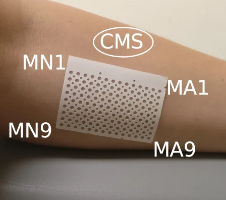

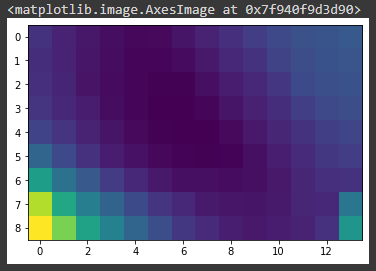

Os movimentos foram caracterizados cada um com um respectivo valor, respeitando a ordem da tabela para se tornar a matriz y.  

$ movements = y= 
\begin{bmatrix}
1\\
9 \\
9 \\
0 \\
0 \\
\vdots \\
2\\
2
\end{bmatrix} 
=
\begin{bmatrix}
cilinder\\
point \\
point \\
3digit \\
3digit \\
\vdots \\
disc\\
disc
\end{bmatrix} 
$


In [ ]:
y = caracteristicas.values[:,[-2]]
b, y = np.unique(y, return_inverse=True)

x = caracteristicas.values[:,0:-2]
x = x.astype(float)

##Train, Test e Validação

Os valores em análise foram divididos em dois grupos, de Treino e de Teste. 

Os valores de treino são usados para que o programa consiga treinar até gerar weights que generalizem o funcionamento da máquina. Para isso esses valores são subdivididos em treino e validação, onde a validação serve para ratificar o weight calculado com os valores de treino.

Os valores de teste por sua vez são usados assim que já estabelecido os hiperparêmetros e weights que geraram melhores resultados na validação.

$\ maps_{train} = x 80\% $

$\ maps_{validacao} = x_{train} 0,5\% $

$\ maps_{test} = x 20\% $

$\ y_{train} = x 80\% $

$\ y_{validacao} = y_{train} 0,5\% $

$\ y_{test} = x 20\% $

In [ ]:
indices = np.arange(len(maps['/meta']))

indices_train_val, indices_test, y_train_val, y_test = train_test_split(indices, y, test_size=0.2, random_state=1, stratify=y)

# indices_train_val = indices_train_val[(y_train_val == 1) | (y_train_val == 2) | (y_train_val == 3) | (y_train_val == 7)]
# indices_test = indices_test[(y_test == 1) | (y_test == 2) | (y_test == 3) | (y_test == 7)]

# y_train_val = y_train_val[(y_train_val == 1) | (y_train_val == 2) | (y_train_val == 3) | (y_train_val == 7)]
# y_test = y_test[(y_test == 1) | (y_test == 2) | (y_test == 3) | (y_test == 7)]


indices_train, indices_val, y_train, y_val = train_test_split(indices_train_val, y_train_val, test_size=50,  random_state=1, stratify=y_train_val)


origN = len(indices_train)
rus = RandomOverSampler()
indices_train, y_train = rus.fit_resample(indices_train.reshape(-1,1), y_train)


# indices_train_sort = np.argsort(indices_train.squeeze())
# indices_train = indices_train[indices_train_sort].squeeze()
# y_train = y_train[indices_train_sort]

# indices_val_sort = np.argsort(indices_val.squeeze())
# indices_val = indices_val[indices_val_sort].squeeze()
# y_val = y_val[indices_val_sort]

# indices_test_sort = np.argsort(indices_test.squeeze())
# indices_test = indices_test[indices_test_sort].squeeze()
# y_test = y_test[indices_test_sort]
y_train.shape

(1235,)

##Escala

Usando a função rescale a escala dos mapas de ativação foram aumentados em n vezes.

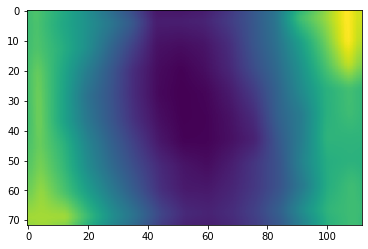

In [ ]:
scale = 8
image_size = (9,14)
mapstrain = np.zeros((len(indices_train), 1, image_size[0]*scale, image_size[1]*scale))
mapsval = np.zeros((len(indices_val), 1, image_size[0]*scale, image_size[1]*scale))
mapstest = np.zeros((len(indices_test), 1, image_size[0]*scale, image_size[1]*scale))

for i in range(len(indices_train)):
  mapstrain[i, 0, :,:] = rescale(maps['/image'][indices_train[i].squeeze(),0,:,:], scale)
#   if i >= origN:  
#     M = np.max(mapstrain[i, 0, :,:])
#     mapstrain[i, 0, :,:] = rotate(mapstrain[i, 0, :,:], 
#                                   angle=-3+6*np.random.rand(1),
#                                   mode='edge')

for i in range(len(indices_val)):
  mapsval[i, 0, :,:] = rescale(maps['/image'][indices_val[i],0,:,:], scale)

for i in range(len(indices_test)):
  mapstest[i, 0, :,:] = rescale(maps['/image'][indices_test[i],0,:,:], scale)

plt.imshow(mapstrain[900,0,:,:])

#Esquema da Rede Neural de n Camadas

O objetivo da rede neural é gerar através do mapa de ativação com valores $x$ valores estimados ($\hat{y}$) muito próximos dos valores reais estabelecidos para cada movimento ($y$)

$  
\begin{vmatrix}
x
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{camada convolucional}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{max pooling}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{Leaky Relu}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{Batch Norm}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{Camada Densa}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{Leaky Relu}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\hat{y}
\end{vmatrix}
\longrightarrow
\begin{vmatrix}
\text{Soft Max}
\end{vmatrix}  
$

##Camada Convolucional

Extrai automaticamente recursos notáveis de uma entrada fornecida e os repassa para a próxima camada na forma de mapas de recursos.

Sendo a primeira entrada o mapa de ativação a primeira camada convolucional, vai "passando" por toda a imagem captando os traços mais marcantes.

Há três parâmetros a serem definidos em uma rede convolucional:


*   Tamanho da janela, neste caso foi usado uma janela 3x3
*   *Stride*: Valor do passo, que é o quanto a janela anda, foi utilizado 1

##*Max pooling*

Dada cada janela de convolução é pego o maior valor dentro dessa janela,como pode ser visto na imagem

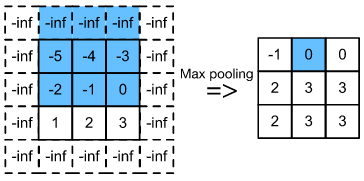

##Rectified Linear Unit

Função de ativação da unidade linear retificada com vazamento.

$\ Leaky Relu (x) = 
\left\{
\begin{array}{lll}
x, & x \geq 0 \\
\alpha x, & x < 0 \\
\end{array}
\right.
$

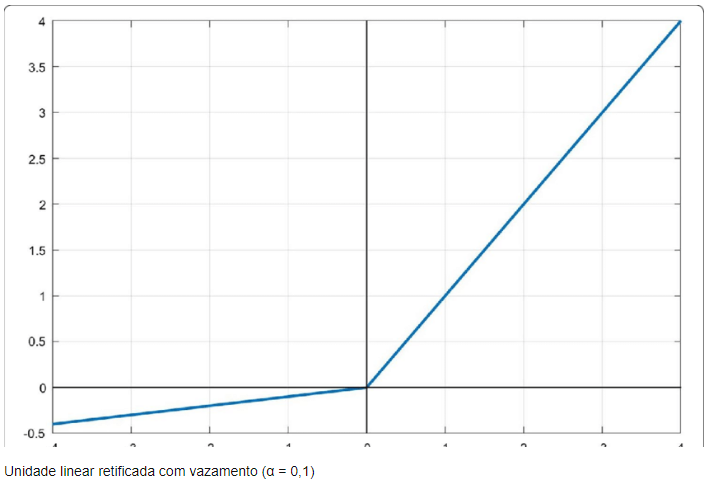

##Batch norm

A batch norm é uma técnica que padroniza os weight de entrada para cada *mini-batch*. Isso tem o efeito de estabilizar o processo de aprendizagem e reduzir drasticamente o número de propagations de treinamento necessárias para treinar redes profundas.

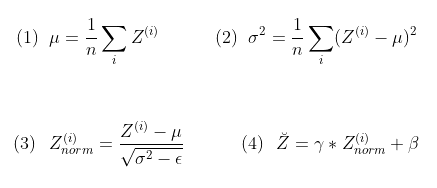

#confirmar essas formulas para escreve-las depois

* Primeiro é calculado a média 𝜇 e a variância σ dos valores de ativação ao longo do lote, usando (1) e (2).

* Em seguida, normaliza o vetor de ativação Z^(i) com (3). Logo, a saída de cada neurônio segue uma distribuição normal. (𝜀 é uma constante usada para estabilidade numérica)

* Por fim, calcula a saída da camada Ẑ(i) aplicando uma transformação linear com 𝛾 e 𝛽 , dois parâmetros treináveis ​​(4). Essa etapa permite que o modelo escolha a distribuição para cada camada, ajustando esses dois parâmetros:

𝛾 permite ajustar o desvio padrão;
𝛽 permite ajustar deslocando a curva para a direita ou para a esquerda.

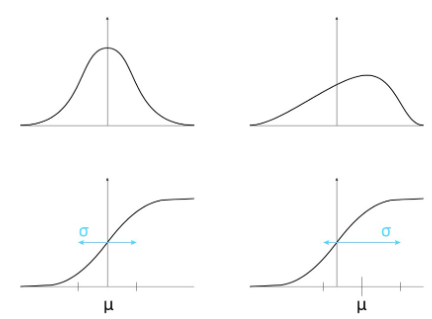

##Softmax

É uma generalização da função exponencial para mais de uma dimensão,depois de aplicar o softmax, cada valor ($\hat{y}$) estará no intervalo (0,1), para serem interpretados como probabilidades. 

$\hat{y_i} = \frac{e^{y_i}}{\sum_j e^{y_j}}$

##Dropout

Elimina aleatoriamente alguns dos neurônios ocultos na rede em alguma propagação, deixando os neurônios de entrada e saída intocados. É determinado a porcentagem de neurônios que serão eliminados.

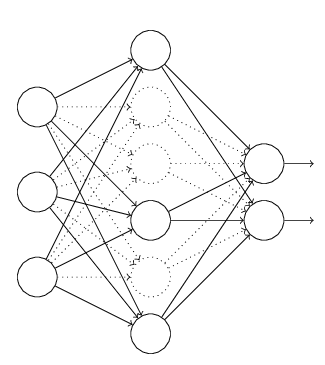

In [ ]:
def dropout(z, drop_rate=0.25, train=False):
  if train:
    z_drop = np.random.rand(z.shape[0],z.shape[1]) > drop_rate
    z = z_drop*z
    z = z/(1-drop_rate)

  return z

def maxpool(x, window):
  window = (1,1,window[0],window[1])
  x = lax.reduce_window(x, -jnp.inf, lax.max, 
                        window_dimensions=window, 
                        window_strides=(1,1,1,1),
                        padding='VALID')
  return x



def rede_3camadas(x, w, train=False, 
                  drop1=0.25, drop2=0.25, 
                  conv_layers=3, m=0, sd=0):
  
  if train:
    m = (conv_layers+1)*[0]
    sd = (conv_layers+1)*[0]
  for i in range(conv_layers):
    x = lax.conv(x, 
                w[3*i],
                (1,1),
                'VALID')
    x = maxpool(x,(2,4))
    x = jax.nn.leaky_relu(x)
    if train:
      sd[i] = jnp.std(x, axis=0)
      m[i] = jnp.mean(x, axis=0)
    x = (x - m[i])/sd[i]
    x = w[3*i+1] + w[3*i+2]*x
    
       
  
  x = x.reshape(x.shape[0],-1)  
  
  x = x @ w[3*conv_layers] 
  x = jax.nn.leaky_relu(x)
  x = dropout(x, drop1, train)
  if train:
    sd[conv_layers] = jnp.std(x, axis=0)
    m[conv_layers] = jnp.mean(x, axis=0)
  x = (x - m[conv_layers])/sd[conv_layers]
  x = w[3*conv_layers+1] + w[3*conv_layers+2]*x  
#   z2 = z1 @ w[3*conv_layers+1]
#   z2 = jax.nn.selu(z2)
#   x = dropout(x, drop2, train)
  y_estimado = x @ w[3*conv_layers+3]

  return y_estimado, m, sd

##Acuracia

É utilizado para ter um valor que mostre o quanto o $\hat{y}$ está próximo do $y$


In [ ]:
def acuracia(A, y) :
  acc = ((np.argmax(A, axis = 1) == y.squeeze()).sum())/len(y)*100
  return acc

##Entropia cruzada
Lost

Usado para encontrar o erro entre as saídas calculadas e os valores reais, o quão longe $\hat{y}$ está de $y$


"Mede o erro de probabilidade em tarefas de classificação discreta nas quais as classes são mutuamente exclusivas (cada entrada está em exatamente uma classe)." (https://optax.readthedocs.io/en/latest/api.html#optax.sigmoid_binary_cross_entropy)

Para isso é preciso que os valores de y estejam no formato one hot, um exemplo desse formato pode ser visto a seguir:



$
\begin{array}{l|l}
Movimento & y \\
cilinder & 1 \\
point & 9 \\
\dots & \dots \\
disc & 2  
\end{array}
$
$\longrightarrow$
$
\begin{array}{l|l|l|l}
Cilinder & point & ... & disc \\
1        & 0     & ... & 0    \\
0        & 1     & ... & 0    \\
...      & ...   & ... & ...  \\
0        & 0     & ... & 1   
\end{array}
$



In [ ]:
def lost(w, x, y, train=False, drop1=0.25, 
         drop2=0.25, conv_layers=10, m=0, sd=0) :
  y_one_hot = jax.nn.one_hot(y, 13)
  y_estimado,_,_ = rede_3camadas(x, w, train, drop1, drop2,conv_layers=conv_layers, m=m, sd=sd)
  L = jnp.mean(optax.softmax_cross_entropy(y_estimado, y_one_hot))
  return L

##Gradiente Descendente

Vetor que se move iterativamente na direção da descida mais íngreme, conforme definido pelo negativo do gradiente.

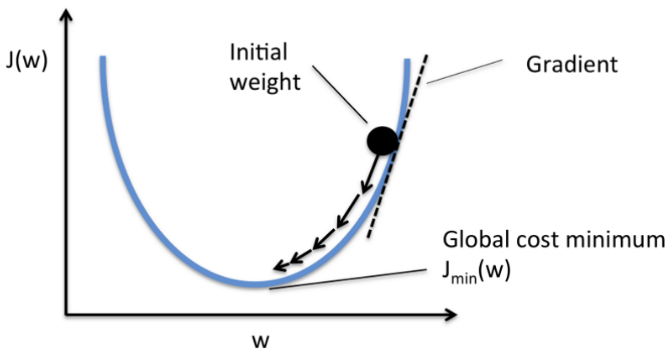



##Adabelief

É utilizado para atingir três objetivos: 
* Convergência rápida como em métodos adaptativos; 
* Boa generalização como em gradiente descendente estocástico (SGD); 
* Estabilidade de treinamento. 

O AdaBelief adapta o *stepsize* de acordo com a "crença" na direção do gradiente atual. Vendo a média móvel exponencial (EMA) do gradiente ruidoso como a previsão do gradiente no próximo passo de tempo, 
* se o gradiente observado se desviar muito da previsão, desconfiamos da observação atual e o passo dado é curto; 
* se o gradiente observado estiver próximo da previsão, confiamos nele e é dado um grande passo.

$
S = 0
$

$
S = \gamma_2 * S + (1-\gamma_2)(\nabla L(w,y)-m)^2
$

$
\hat{S} = \frac{S}{1-\gamma_2^i}
$

$
w[i+1]=w[i]-α*\frac{\hat{m}}{\sqrt{s}+e}
$

$
\hat{m} = \frac{m}{1-\gamma_2^i}
$

In [ ]:
vetor_gradiente1 = jax.value_and_grad(lost)

##Aprendizagem

$  
x \longrightarrow \hat{y}(w,x) \longrightarrow L(\hat{y}, y) \longrightarrow \nabla L_{w_1}, \nabla L_{w_2} , ... \longrightarrow $ atualiza os $w$ 



Forward Propagation: 

$  
x \longrightarrow \hat{y}(w,x) \longrightarrow L(\hat{y}, y) $ 


Back Propagation:

$ 
L(\hat{y}, y) \longrightarrow \nabla L_{w_1}, \nabla L_{w_2} , ... \longrightarrow $ atualiza os $w$

In [ ]:
def aprendizagem_validacao1(w_r, x_t, y_t, x_v, y_v, 
                            a, n, drop1=0.25, drop2=0.25, 
                            gamma=0.9, conv_layers=10):
  acc_est = []
  acc_val = []
  loss_val = []
  w = []
  upd_vector = len(w_r)*[0]
  optimizer = optax.adabelief(learning_rate=a)
  opt_state = optimizer.init(w_r)
  for i in range(n) :
    L, gradiente_est = vetor_gradiente1(w_r, x_t, y_t, train=True, drop1=drop1, drop2=drop2, conv_layers=conv_layers)
    updates, opt_state = optimizer.update(gradiente_est, opt_state, w_r)
    w_r = optax.apply_updates(w_r, updates)
    
    # for j in range(len(w_r)):
    #   upd_vector[j] = gamma*upd_vector[j] + (1-gamma)*gradiente_est[j]
    #   w_r[j] = w_r[j] - a*upd_vector[j]
      
    w.append(w_r)
    
    #print(i, w[i], gradiente_est[0])
    A_est, m,sd = rede_3camadas(x_t, w[i], conv_layers=conv_layers, train=True, drop1=0,drop2=0)
    Acc_est = acuracia(A_est, y_t)
    acc_est.append(Acc_est)
    
    #w.append(w_r)

    A_val,_,_ = rede_3camadas(x_v, w[i], conv_layers=conv_layers, m=m,sd=sd)
    Acc_val = acuracia(A_val, y_v)
    acc_val.append(Acc_val)
    L_val = lost(w[i], x_v, y_v, conv_layers=conv_layers, m=m,sd=sd)
    loss_val.append(L_val)
    if i%1000 == 0:
      print(i, 'acc_train', Acc_est, 'acc_val', Acc_val, 'loss', L, 'loss_val', L_val)
  
  w = w[np.argmax(acc_val)]

  return acc_est, acc_val, w, loss_val, m,sd

In [ ]:
f = open('/content/drive/MyDrive/dicionario/w1.pkl','rb')
w = pickle.load(f)
w[10]

array(-0.6323683, dtype=float32)

#Train

##Optuna

Busca amostral dos hiperparâmetros.

É definido quais hiperparâmetros deverão ser otimizados, para isso é dado um intervalo para o hiperparâmetro, quantos testes serão realizados, qual o objetivo.

Para esse caso as variaveis são:
* n1 e n2 sendo o número de neurônios das camadas densas 
* a: a taxa de aprendizagem
* drop1 e drop2: a porcentagem de remoção dos dropout

In [ ]:
def objective(trial):
    conv_layers = 1

    n1 = trial.suggest_int('n1', 40, 60)
    n2 = 0#trial.suggest_int('n2', 2, 10)
    a = 0.001#trial.suggest_float('a', 0.0001, 0.001, log=True)
    drop1 = 0#trial.suggest_float('drop1', 0.3, 0.9)
    drop2 = 0#trial.suggest_float('drop2', 0.3, 0.9)
    
    
    
    image_size = (9*scale,14*scale)
    kernel_size = (3,3)
    maxpoolsize = (2,4)
    
    o = dict()
    o[0] = image_size
    for i in range(1,conv_layers+1):
      o[i] = (int(np.floor((o[i-1][0]-kernel_size[0])/1) + 1), 
          int(np.floor((o[i-1][1]-kernel_size[1])/1) + 1))
      o[i] = (int(np.floor((o[i][0]-maxpoolsize[0])/1) + 1), 
          int(np.floor((o[i][1]-maxpoolsize[1])/1) + 1))
      print(o[i])
    
    w_random=dict()
    
    for i in range(conv_layers):
      w_random[3*i] = np.random.randn(1,1,kernel_size[0],kernel_size[1])/np.sqrt(9)
      w_random[3*i+1] = 0.0
      w_random[3*i+2] = 1.0
    w_random[3*conv_layers] = np.random.randn(o[conv_layers][0]*o[conv_layers][1],n1)/np.sqrt(n1*o[conv_layers][0]*o[conv_layers][1])
    # w_random[3*conv_layers+1] = np.random.randn(n1,n2)/np.sqrt(n1*n2)
    w_random[3*conv_layers+1] = 0.0
    w_random[3*conv_layers+2] = 1.0
    w_random[3*conv_layers+3] = np.random.randn(n1,13)/np.sqrt(n1*13)      
    
    # f = open('/content/drive/MyDrive/dicionario/w2.pkl','rb')
    # w_random = pickle.load(f)
  
    
    maps_M = mapstrain.mean(axis=0)
    maps_SD = mapstrain.std(axis=0)
    
    acc_estimado, acc_validacao, w, loss_val, m,sd = aprendizagem_validacao1(w_random, 
                                                         (mapstrain-maps_M)/maps_SD, y_train, 
                                                         (mapsval-maps_M)/maps_SD, y_val,
                                                         a, 2000, drop1=drop1, drop2=drop2,
                                                         gamma=0.99, conv_layers=conv_layers)
    plt.figure()
    plt.plot(acc_estimado, 'r')
    plt.plot(acc_validacao, 'b')
    plt.show()
    f = open('/content/drive/MyDrive/dicionario/w3.pkl','wb')
    pickle.dump(w, f)
    A_test,_,_ = rede_3camadas((mapstest-maps_M)/maps_SD, w, conv_layers=conv_layers, m=m, sd=sd)
    Acc_test = acuracia(A_test, y_test)
    print(Acc_test)

    return np.array(acc_validacao)[np.argmax(acc_validacao)]

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

study.best_params 

[I 2022-06-26 10:05:48,804] A new study created in memory with name: no-name-e48ebbd9-d849-4881-b7de-13a79d7127a6


(69, 107)
(66, 102)


KeyboardInterrupt: ignored

#Test